In [196]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [197]:
target = "PM2.5"
dataset = "cpcb_ijcai24_dec23"
res_dict = {}
for config in ["config_s", "config_sp1", "config_p1", "config_se", "config_st", "config_sw", "config_sh", "config_std", "config_sp3"]:
    # for model in ["lr", "mean", "rf", "1nn", "idw", "kriging", "deeptime", "zcnp", "convgnp"]:
    for model in ["lr", "mean", "rf", "idw", "1nn", "moe", "zcnp", "kriging"]:
        if model in ["mean", "idw", "1nn", "kriging"] and config != "config_s":
            continue
        res_dict[f"{model}_{config}"] = {}
        for fold in range(4):
            try:
                with xr.open_dataset(f"/opt/aqmsp_models/models/{config}/{model}/{dataset}/config1/fold_{fold}/predictions.nc") as res_ds:
                    pass
                # print(res_ds)
                # select ds with non-nan values
                res_df = res_ds.to_dataframe().reset_index()
                res_df = res_df[res_df[f"{target}_missing"] == False]
                rmse = np.sqrt(np.mean((res_df[target] - res_df[f"{target}_pred"])**2))
                res_dict[f"{model}_{config}"][fold] = rmse
                # rmse = res_df.groupby("station").apply(lambda x: np.sqrt(np.mean((x[target] - x[f"{target}_pred"])**2))).mean()
                # res_dict[f"{model}_{config}"][fold] = rmse
            except Exception as e:
                # print(f"Error: {e}")
                res_dict[f"{model}_{config}"][fold] = np.nan
        
df = pd.DataFrame(res_dict).T
df["mean"] = df.mean(axis=1)
df.sort_values("mean", inplace=True)
df

,0,1,2,3,mean
lr_config_sp3,58.509299,54.136824,52.234262,62.770041,56.912607
lr_config_sp1,56.948081,53.195010,53.366293,64.388227,56.974403
kriging_config_s,57.356483,54.626040,50.217650,68.149651,57.587456
idw_config_s,58.247256,53.277242,51.149627,68.337966,57.753022
moe_config_sp1,58.299109,54.136145,53.323298,65.535554,57.823527
rf_config_sp1,61.172246,53.056703,53.682776,68.406074,59.079450
lr_config_p1,58.261859,57.820561,56.243419,64.328214,59.163513
rf_config_sp3,59.254952,55.319183,53.193207,69.308864,59.269052
lr_config_st,58.459591,59.103948,54.415352,65.732296,59.427797
lr_config_sh,58.213436,58.087931,55.703362,67.589851,59.898645


In [198]:
model = "rf"
fold = 3
show_df = pd.DataFrame()
for config in ["config_dec23_s", "config_dec23_sw"]:
    with xr.open_dataset(f"/opt/aqmsp_models/models/{config}/{model}/cpcb_ijcai24/config1/fold_{fold}/predictions.nc") as res_ds:
        res_df = res_ds.to_dataframe().reset_index()

    tmp_series = res_df.groupby("station").apply(lambda x: np.sqrt(np.mean((x[target] - x[f"{target}_pred"])**2)))
    show_df[config] = tmp_series
show_df

FileNotFoundError: [Errno 2] No such file or directory: '/opt/aqmsp_models/models/config_dec23_s/rf/cpcb_ijcai24/config1/fold_3/predictions.nc'

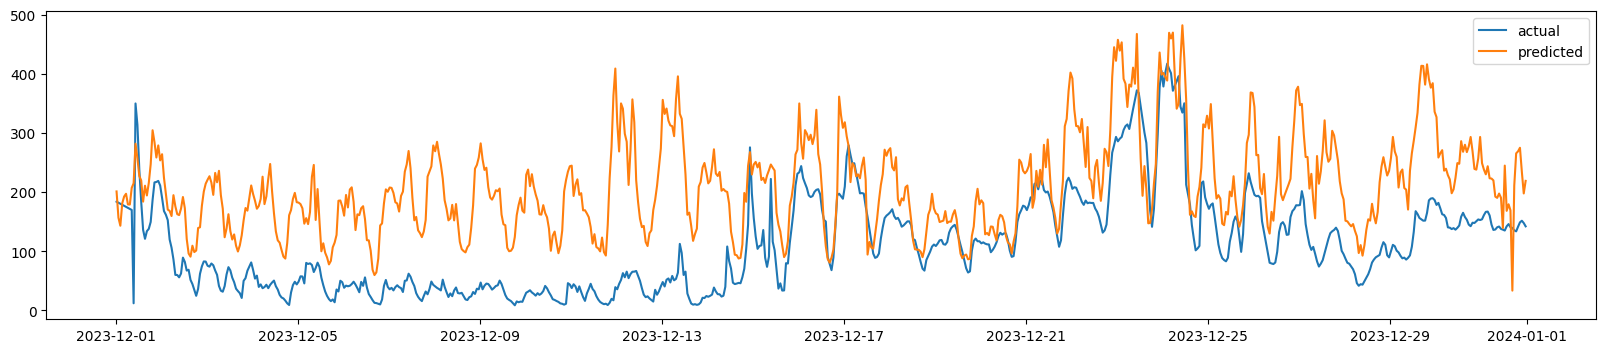

In [ ]:
sdf = res_df[res_df['station'] == "Arya_Nagar_Bahadurgarh_HSPCB"]
plt.figure(figsize=(20, 4))
plt.plot(sdf['time'], sdf[target], label="actual")
plt.plot(sdf['time'], sdf[f"{target}_pred"], label="predicted")
plt.legend();

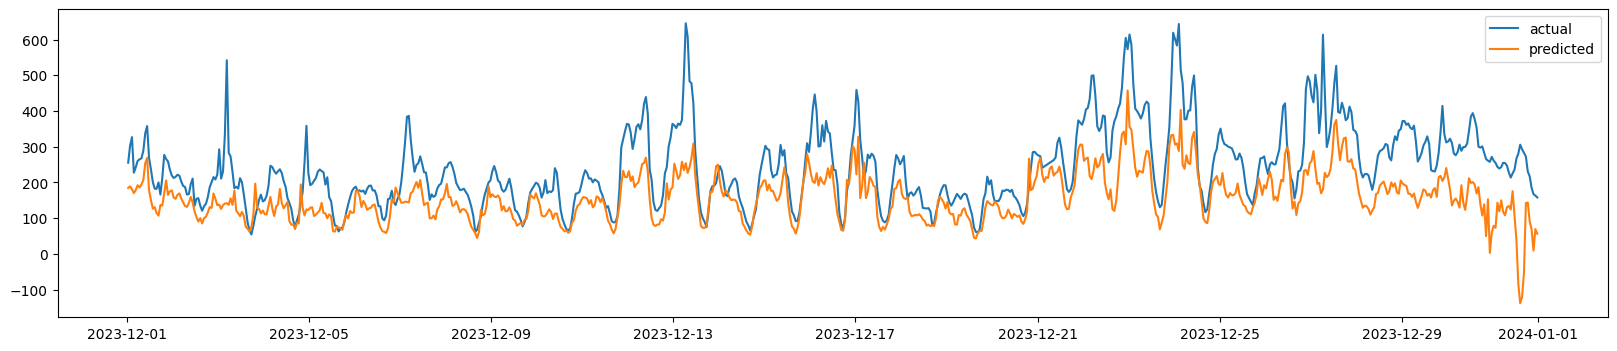

In [ ]:
sdf = res_df[res_df['station'] == "Anand_Vihar_Delhi_DPCC"]
plt.figure(figsize=(20, 4))
plt.plot(sdf['time'], sdf[target], label="actual")
plt.plot(sdf['time'], sdf[f"{target}_pred"], label="predicted")
plt.legend();

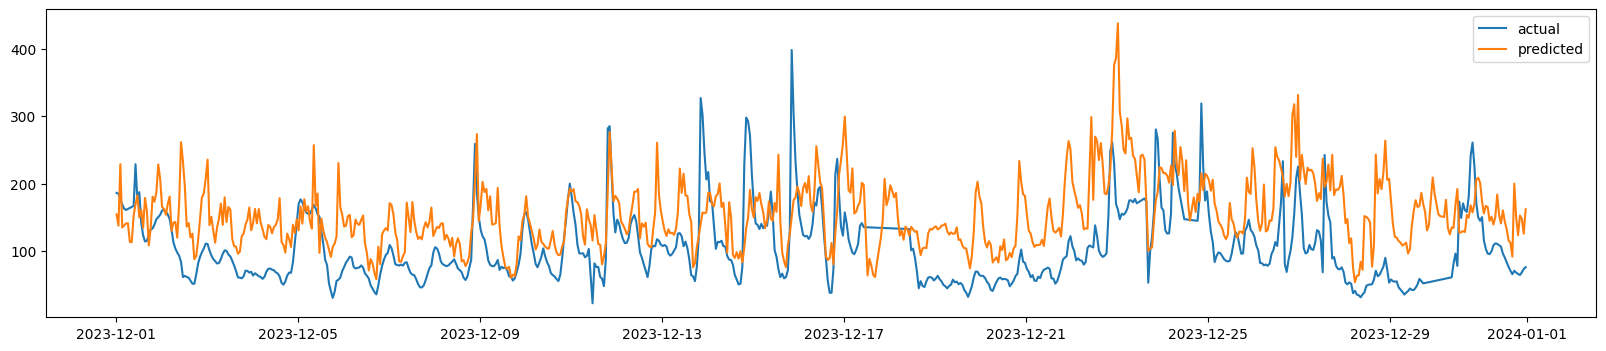

In [ ]:
sdf = res_df[res_df['station'] == "Sector_2_IMT_Manesar_HSPCB"]
plt.figure(figsize=(20, 4))
plt.plot(sdf['time'], sdf[target], label="actual")
plt.plot(sdf['time'], sdf[f"{target}_pred"], label="predicted")
plt.legend();